In [1]:
from nems_lbhb.baphy_experiment import BAPHYExperiment
import charlieTools.baphy_remote as br
import charlieTools.noise_correlations as nc
from charlieTools.plotting import compute_ellipse
from sklearn.decomposition import PCA
import nems.db as nd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2020-09-07 135137.log


## REFERENCE ONLY summaries
* highlight effect of adaption on responses

#### Global settings / loading options

In [83]:
# recording loading options
options = {'resp': True, 'pupil': False, 'rasterfs': 10}

# hardcode stim onset / offset bins to avoid loading exptevents
ref_dur = int(0.3 * options['rasterfs'])
onset = int(0.1 * options['rasterfs'])
offset = int(0.3 * options['rasterfs'])

# fig save path
fig_path = '/auto/users/hellerc/code/projects/in_progress/TIN_behavior/dump_figs/'

# siteids
sites = ['CRD010b']  #['CRD009b', 'CRD010b', 'CRD011c', 'CRD012b', 'CRD013b', 'CRD016c', 'CRD017c', 'CRD018d', 'CRD019b']

# zscore for state-space projections?
zscore = False

#### Loop over sites, load data, save in dict of recordings

In [84]:
rdict = dict.fromkeys(sites)
for site in sites:
    if os.path.isdir(os.path.join(fig_path, site)):
        pass
    else:
        os.mkdir(os.path.join(fig_path, site))
    
    site_path = os.path.join(fig_path, site)
    # get parmfiles
    sql = "SELECT sCellFile.cellid, sCellFile.respfile, gDataRaw.resppath from sCellFile INNER JOIN" \
               " gCellMaster ON (gCellMaster.id=sCellFile.masterid) INNER JOIN" \
               " gDataRaw ON (sCellFile.rawid=gDataRaw.id)" \
               " WHERE gCellMaster.siteid=%s" \
               " and gDataRaw.runclass='TBP' and gDataRaw.bad=0"
    d = nd.pd_query(sql, (site,))
    d['parmfile'] = [f.replace('.spk.mat', '.m') for f in d['respfile']]
    parmfiles = np.unique(np.sort([os.path.join(d['resppath'].iloc[i], d['parmfile'].iloc[i]) for i in range(d.shape[0])])).tolist()
    manager = BAPHYExperiment(parmfiles)
    rec = manager.get_recording(**options)
    rec['resp'] = rec['resp'].rasterize()

    rdict[site] = rec

[nems_lbhb.baphy_experiment INFO] Cached recording found


#### For each site, extract REF responses and plot data

[matplotlib.legend WARNING] No handles with labels found to put in legend.


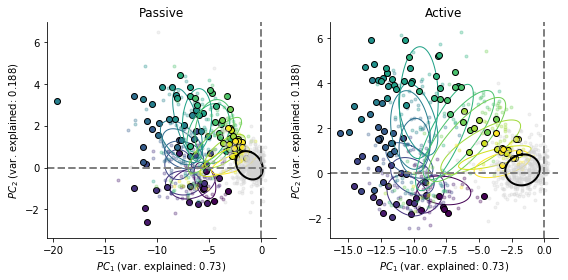

In [85]:
for site in sites:
    rec = rdict[site].copy()

    # extract / sort ref stim epochs
    ref_stims = [x for x in rec['resp'].epochs.name.unique() if 'STIM_' in x]
    idx = np.argsort([int(s.split('_')[-1]) for s in ref_stims])
    ref_stims = np.array(ref_stims)[idx].tolist()

    # PCA on trial averaged ref responses, collapsed over duration
    rall = rec.copy()
    rall = rall.create_mask(True)
    rall = rall.and_mask(['HIT_TRIAL', 'MISS_TRIAL', 'INCORRECT_HIT_TRIAL', 'CORRECT_REJECT_TRIAL', 'PASSIVE_EXPERIMENT'])
    # can't simply extract evoked for refs because can be longer/shorted if it came after target 
    # and / or if it was the last stim.So, masking prestim / postim doesn't work.Do it manually
    d = rall['resp'].extract_epochs(ref_stims, mask=rall['mask'])
    d = {k: v[~np.isnan(v[:, :, onset:offset].sum(axis=(1, 2))), :, :] for (k, v) in d.items()}
    d = {k: v[:, :, onset:offset] for (k, v) in d.items()}

    # zscore each neuron, if zscore is true
    m = np.concatenate([d[e] for e in d.keys()], axis=0).mean(axis=-1).mean(axis=0)
    sd = np.concatenate([d[e] for e in d.keys()], axis=0).mean(axis=-1).std(axis=0)
    if zscore:
        d = {k: (v.transpose(0, -1, 1) - m).transpose(0, -1, 1)  for (k, v) in d.items()}
        d = {k: (v.transpose(0, -1, 1) / sd).transpose(0, -1, 1)  for (k, v) in d.items()}

    # do PCA
    Rall_u = np.vstack([d[k].sum(axis=2).mean(axis=0) for k in d.keys()])

    pca = PCA(n_components=2)
    pca.fit(Rall_u)
    pc_axes = pca.components_

    # define ACTIVE / PASSIVE response dictionaries. Divide into trial onset / not trial onset data
    ra = rec.copy().create_mask(True)
    ra = ra.and_mask(['HIT_TRIAL', 'MISS_TRIAL', 'CORRECT_REJECT_TRIAL'])
    aTrial_onsets = ra['resp'].get_epoch_indices('TRIAL', mask=ra['mask'])[:, 0]
    aEpoch_onsets = {k: ra['resp'].get_epoch_indices(k, mask=ra['mask'])[:, 0] for k in ref_stims}
    onset_mask = {k: np.array([True if o in aTrial_onsets else False for o in aEpoch_onsets[k]]) for k in aEpoch_onsets.keys()}
    da = ra['resp'].extract_epochs(ref_stims, mask=ra['mask'])
    da = {k: v[:, :, onset:offset] for (k, v) in da.items()}
    onset_mask = {k: onset_mask[k][~np.isnan(da[k].sum(axis=(1, 2)))] for k in onset_mask.keys()}
    da = {k: v[~np.isnan(v.sum(axis=(1, 2))), :, :] for (k, v) in da.items()}
    if zscore:
        da = {k: (v.transpose(0, -1, 1) - m).transpose(0, -1, 1)  for (k, v) in da.items()}
        da = {k: (v.transpose(0, -1, 1) / sd).transpose(0, -1, 1)  for (k, v) in da.items()}
    
    da_onsets = {k: v[onset_mask[k], :, :] for k, v in da.items()}
    da = {k: v[~onset_mask[k], :, :] for k, v in da.items()}

    da_spont = ra['resp'].extract_epochs('PreStimSilence', mask=ra['mask'])
    da_spont = {k: v[~np.isnan(v.sum(axis=(1, 2))), :, :] for (k, v) in da_spont.items()}

    rp = rec.copy().create_mask(True)
    rp = rp.and_mask(['PASSIVE_EXPERIMENT'])
    pTrial_onsets = ra['resp'].get_epoch_indices('TRIAL', mask=rp['mask'])[:, 0]
    pEpoch_onsets = {k: rp['resp'].get_epoch_indices(k, mask=rp['mask'])[:, 0] for k in ref_stims}
    onset_mask = {k: np.array([True if o in pTrial_onsets else False for o in pEpoch_onsets[k]]) for k in pEpoch_onsets.keys()}
    dp = rp['resp'].extract_epochs(ref_stims, mask=rp['mask'])
    dp = {k: v[:, :, onset:offset] for (k, v) in dp.items()}
    onset_mask = {k: onset_mask[k][~np.isnan(dp[k].sum(axis=(1, 2)))] for k in onset_mask.keys()}
    dp = {k: v[~np.isnan(v.sum(axis=(1, 2))), :, :] for (k, v) in dp.items()}
    if zscore:
        dp = {k: (v.transpose(0, -1, 1) - m).transpose(0, -1, 1)  for (k, v) in dp.items()}
        dp = {k: (v.transpose(0, -1, 1) / sd).transpose(0, -1, 1)  for (k, v) in dp.items()}
    
    dp_onsets = {k: v[onset_mask[k], :, :] for k, v in dp.items()}
    dp = {k: v[~onset_mask[k], :, :] for k, v in dp.items()}

    dp_spont = rp['resp'].extract_epochs('PreStimSilence', mask=rp['mask'])
    dp_spont = {k: v[~np.isnan(v.sum(axis=(1, 2))), :, :] for (k, v) in dp_spont.items()}

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    colors = plt.cm.get_cmap('viridis', len(ref_stims))
    col = 0
    # plot each epoch. Check indices of each single trial to see if it coincided with trial starts
    trial_onsets = rec['resp'].get_epoch_indices('TRIAL')[:, 0]
    for e in ref_stims:
        try:
            passive = dp[e].mean(axis=-1).dot(pc_axes.T)
            ax[0].plot(passive[:, 0], passive[:, 1], alpha=0.3, marker='.', lw=0, color=colors(col))
            el = compute_ellipse(passive[:, 0], passive[:, 1])
            ax[0].plot(el[0], el[1], lw=1, color=ax[0].get_lines()[-1].get_color())

            try:
                passive = dp_onsets[e].mean(axis=-1).dot(pc_axes.T)
                ax[0].plot(passive[:, 0], passive[:, 1], alpha=1, marker='o', 
                            markeredgecolor='k', markeredgewidth=1,
                            lw=0, color=colors(col))
            except:
                pass
        except:
            pass

        try:
            active = da[e].mean(axis=-1).dot(pc_axes.T)
            ax[1].plot(active[:, 0], active[:, 1], alpha=0.3, marker='.', lw=0, color=colors(col))
            el = compute_ellipse(active[:, 0], active[:, 1])
            ax[1].plot(el[0], el[1], lw=1, color=ax[1].get_lines()[-1].get_color())

            try:
                active = da_onsets[e].mean(axis=-1).dot(pc_axes.T)
                ax[1].plot(active[:, 0], active[:, 1], alpha=1, marker='o', 
                        markeredgecolor='k', markeredgewidth=1,
                        lw=0, color=colors(col))
            except:
                pass
        except: 
            pass
        col += 1

    # plot the spont distributions
    passive = dp_spont['PreStimSilence'].mean(axis=-1).dot(pc_axes.T)
    active = da_spont['PreStimSilence'].mean(axis=-1).dot(pc_axes.T)

    ax[0].plot(passive[:, 0], passive[:, 1], alpha=0.3, marker='.', lw=0, color='lightgrey')
    el = compute_ellipse(passive[:, 0], passive[:, 1])
    ax[0].plot(el[0], el[1], lw=2, color='k')

    ax[1].plot(active[:, 0], active[:, 1], alpha=0.3, marker='.', lw=0, color='lightgrey')
    el = compute_ellipse(active[:, 0], active[:, 1])
    ax[1].plot(el[0], el[1], lw=2, color='k')

    ax[0].axhline(0, linestyle='--', lw=2, color='grey')
    ax[0].axvline(0, linestyle='--', lw=2, color='grey')
    ax[1].axhline(0, linestyle='--', lw=2, color='grey')
    ax[1].axvline(0, linestyle='--', lw=2, color='grey')

    ax[0].set_title('Passive')
    ax[1].set_title('Active')
    ax[0].set_xlabel(r'$PC_1$ (var. explained: {})'.format(round(pca.explained_variance_ratio_[0], 3)))
    ax[1].set_xlabel(r'$PC_1$ (var. explained: {})'.format(round(pca.explained_variance_ratio_[0], 3)))
    ax[0].set_ylabel(r'$PC_2$ (var. explained: {})'.format(round(pca.explained_variance_ratio_[1], 3)))
    ax[1].set_ylabel(r'$PC_2$ (var. explained: {})'.format(round(pca.explained_variance_ratio_[1], 3)))

    ax[0].legend(frameon=False, fontsize=6)

    fig.canvas.set_window_title("PCA decompostion")

    fig.tight_layout()

    fig.savefig(site_path + '/PCA_space.png')

In [86]:
da_spont['PreStimSilence'].shape

(435, 38, 1)

In [79]:
    passive = dp_spont['PreStimSilence'].mean(axis=-1).dot(pc_axes.T)
    active = da_spont['PreStimSilence'].mean(axis=-1).dot(pc_axes.T)

In [80]:
passive.shape

(443, 2)